In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

from colorama import Style, Fore
from sklearn.preprocessing import StandardScaler, LabelEncoder
import missingno as msno
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
# Load the original data
data  = pd.read_csv('Churn_Modelling.xls')

# Rename columns for clarity, 
data.columns = ['RowNumber', 'CustomerID', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
                          'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']



In [3]:
# Create a new feature 'CreditPerAge' representing credit score per age
data['CreditPerAge'] = data['CreditScore'] / data['Age']

# Create a new feature 'BalanceToSalaryRatio' representing the ratio of balance to estimated salary
data['BalanceToSalaryRatio'] = data['Balance'] / data['EstimatedSalary']

In [4]:
data.head()

,RowNumber,CustomerID,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditPerAge,BalanceToSalaryRatio
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,14.738095,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,14.829268,0.744677
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,11.952381,1.401375
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,17.923077,0.000000
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,19.767442,1.587055


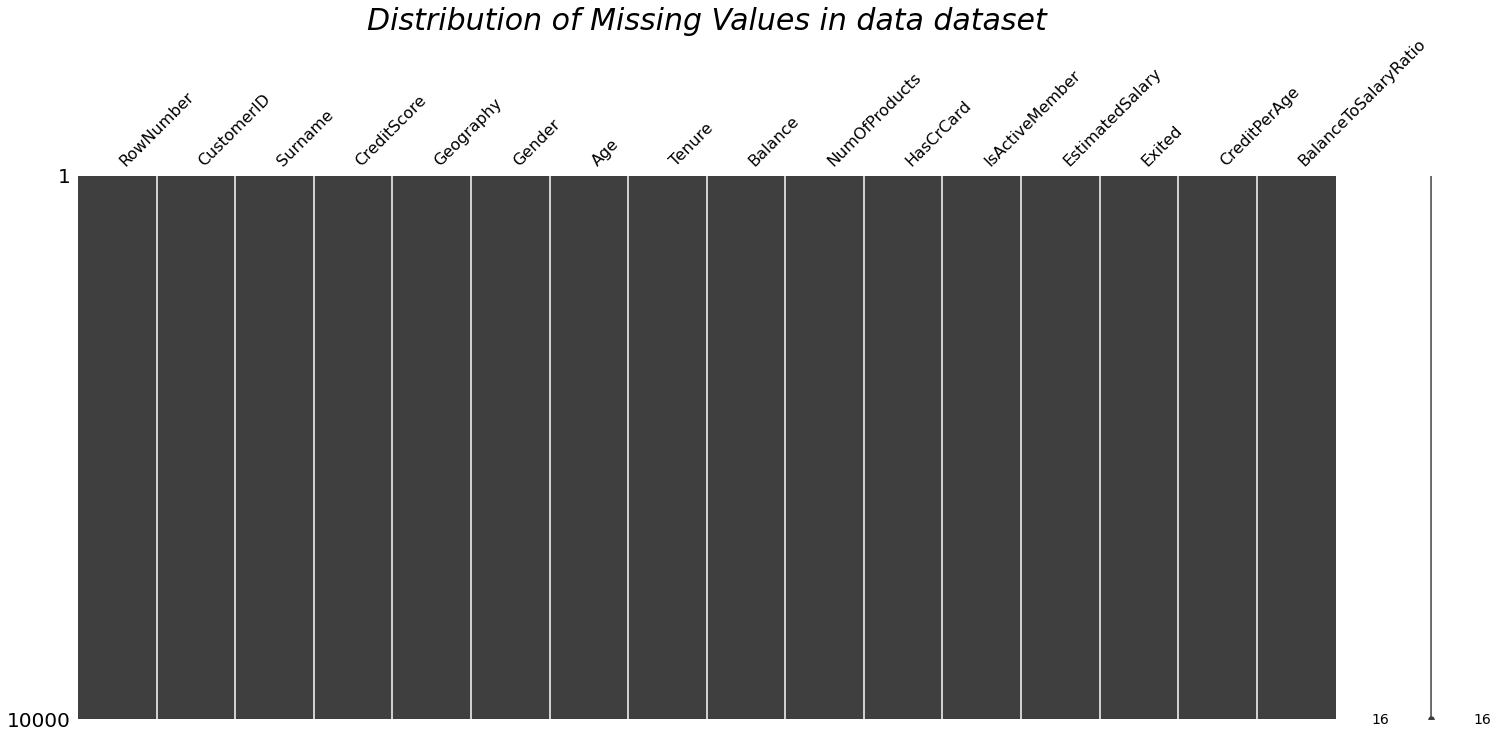

In [5]:
# Explore missing values
def plot_missing_values(df, dataset_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {dataset_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_missing_values(data, "data")

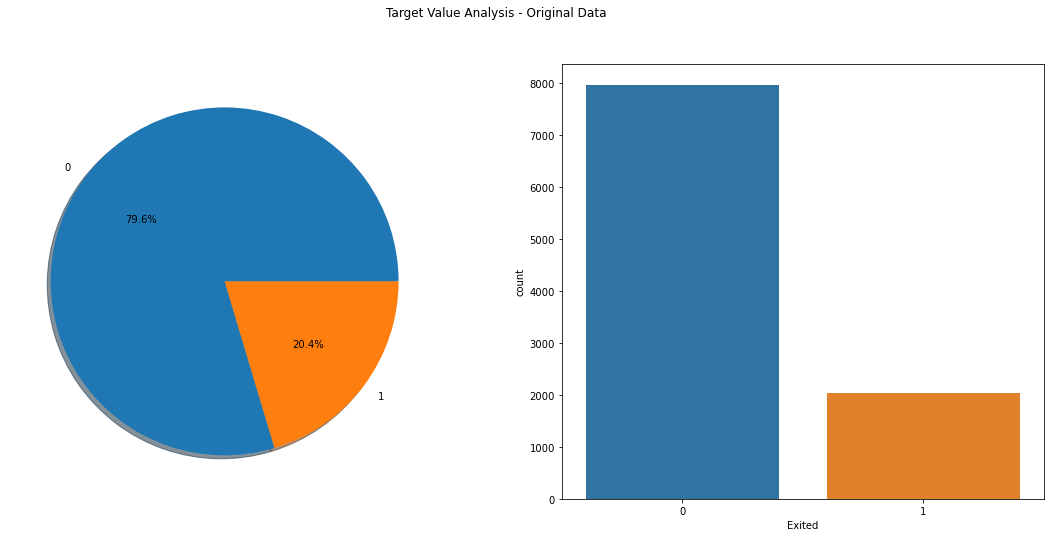

In [6]:
# Visualize target distribution for original data
f, ax = plt.subplots(1, 2, figsize=(19, 8))
data['Exited'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited', data=data, ax=ax[1])
plt.suptitle('Target Value Analysis - Original Data')
plt.show()

In [7]:
# Unique value counts for each column
unique_counts = data.nunique()
threshold = 12

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()


In [8]:
# Removing the 'Exited' from categorical since it's our target variable
if 'Exited' in categorical_vars:
    categorical_vars.remove('Exited')
if 'CustomerID' in continuous_vars:
    continuous_vars.remove('CustomerID')


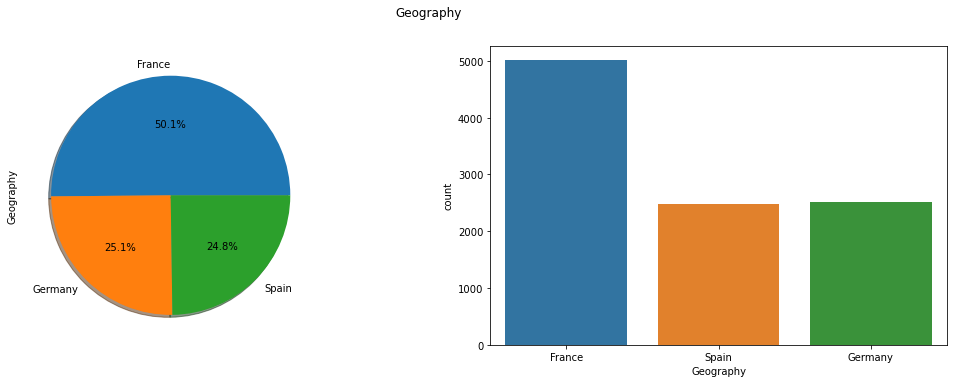

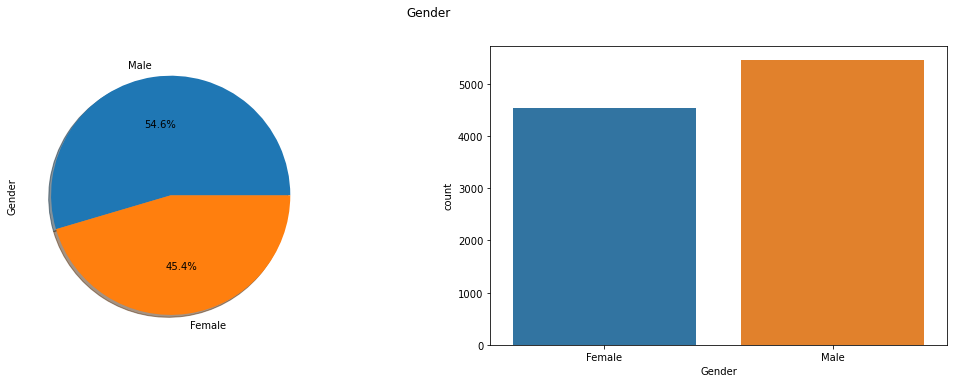

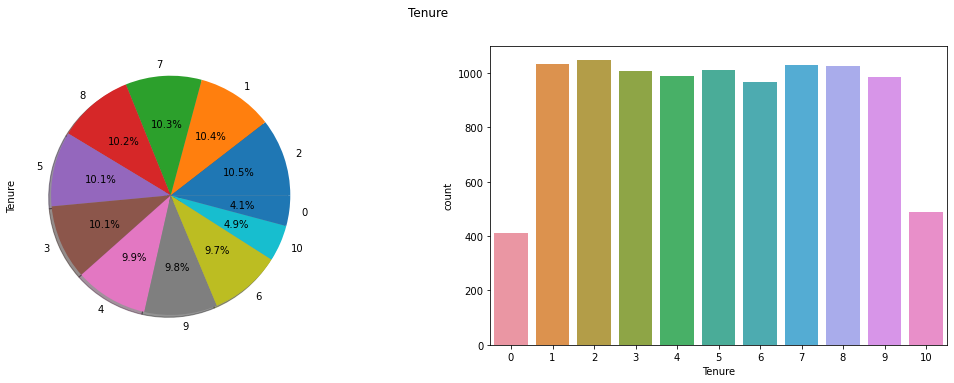

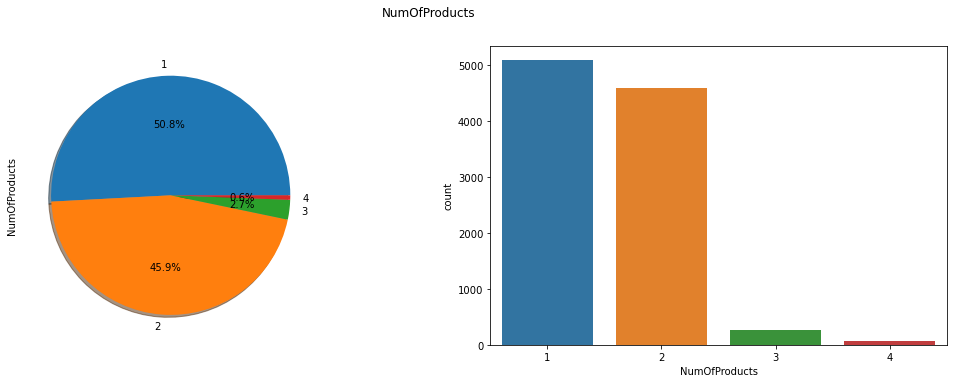

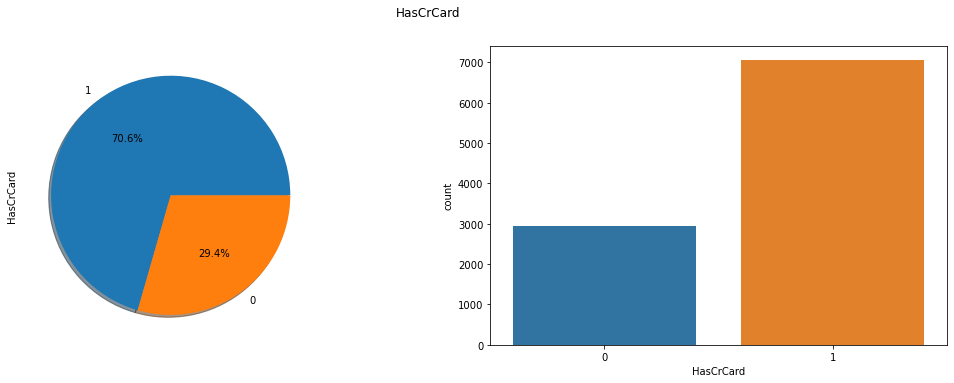

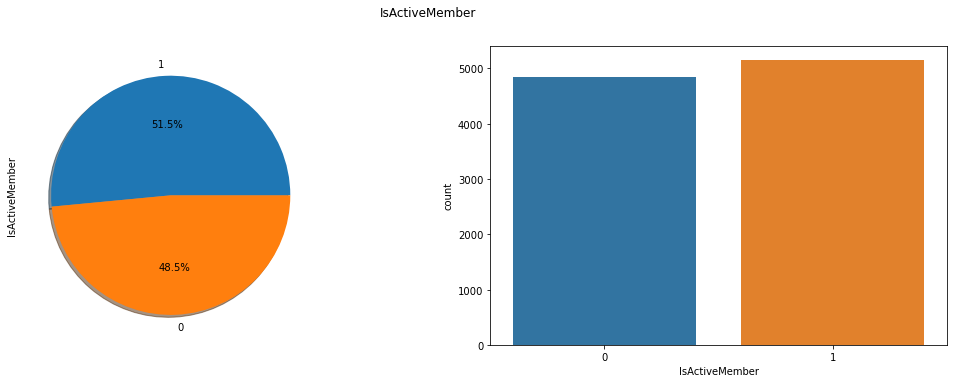

In [9]:
# Visualize categorical variables
for column in categorical_vars:
    f, ax = plt.subplots(1, 2, figsize=(18, 5.5))
    data[column].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column, data=data, ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

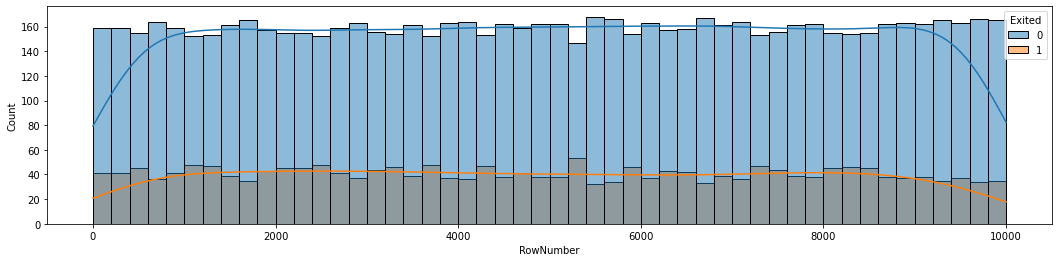

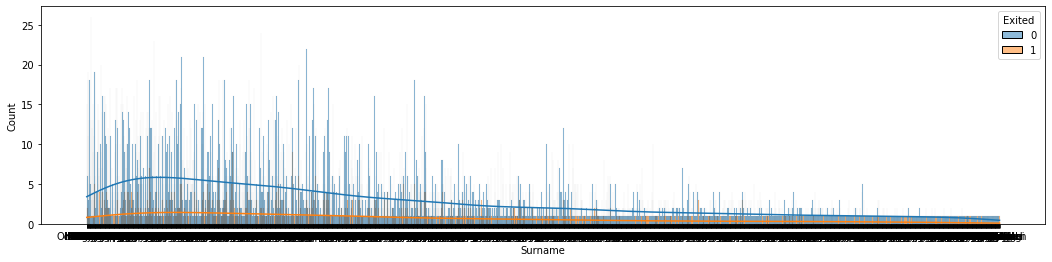

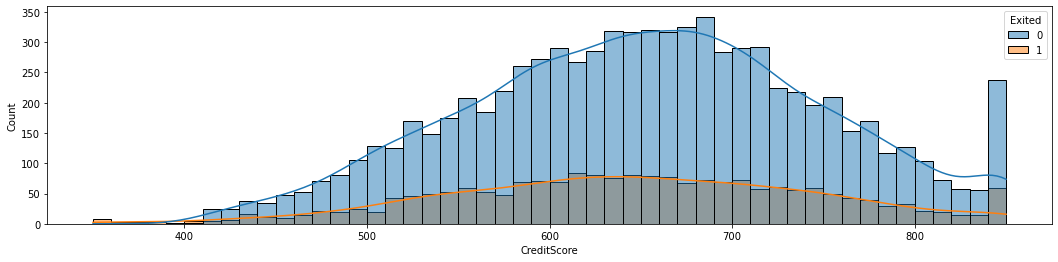

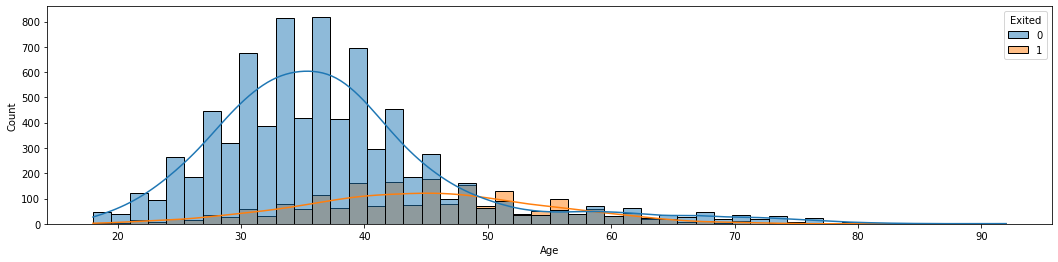

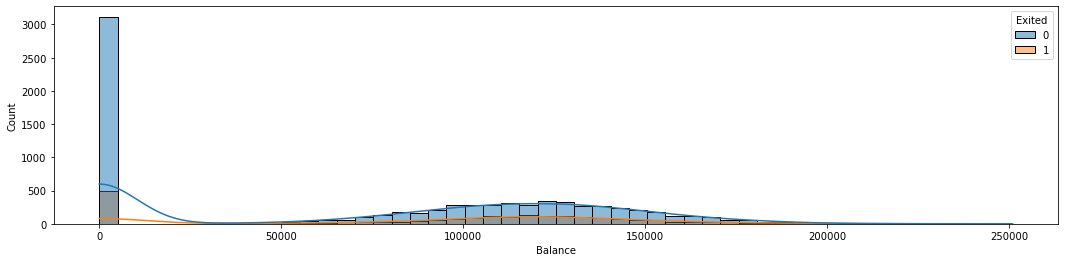

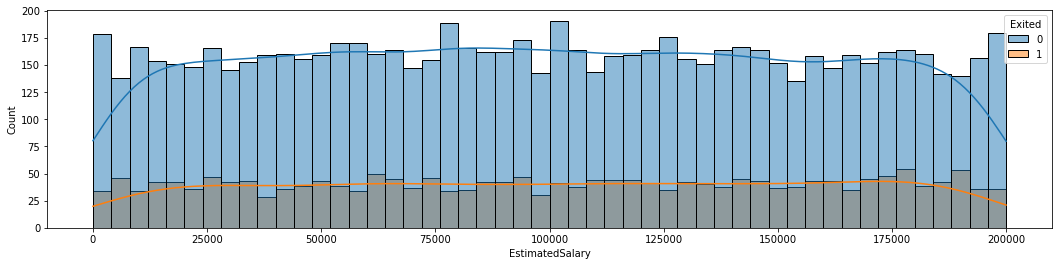

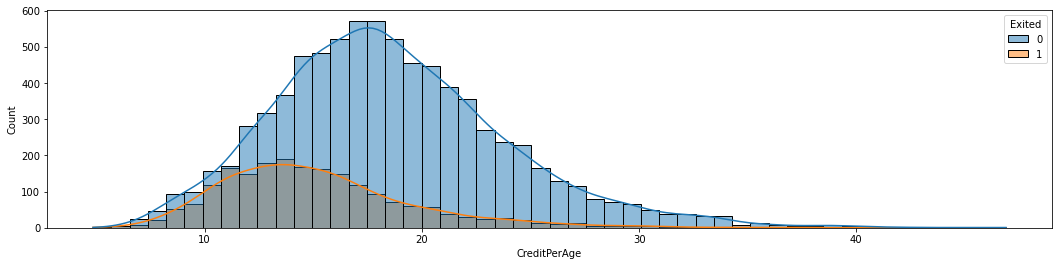

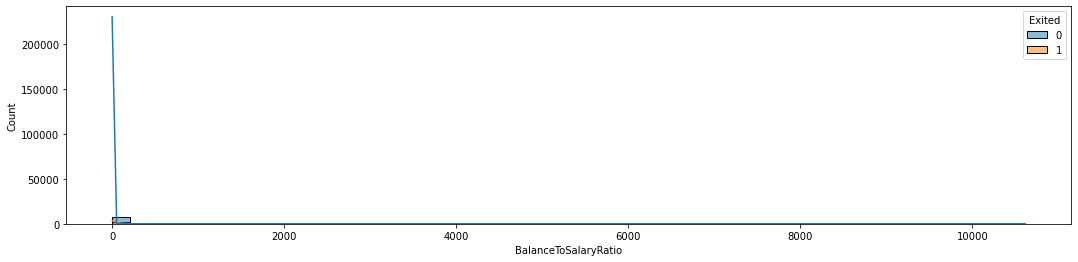

In [10]:
# Visualize continuous variables
for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

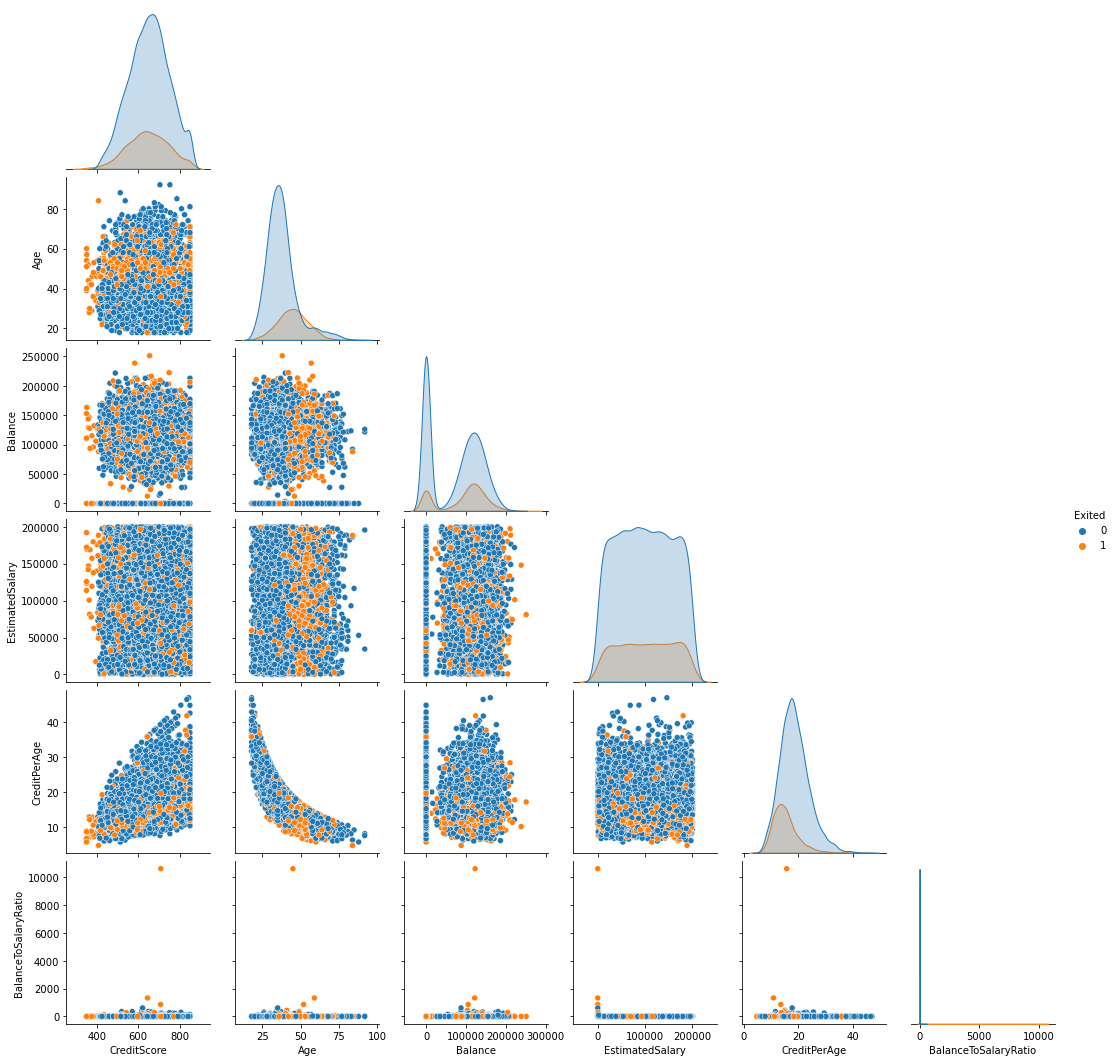

In [11]:
# Feature selection and correlation analysis
selected_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'CreditPerAge', 'BalanceToSalaryRatio', 'Exited']
df_selected = data[selected_features]
sns.pairplot(df_selected, hue="Exited", corner=True)
plt.show()

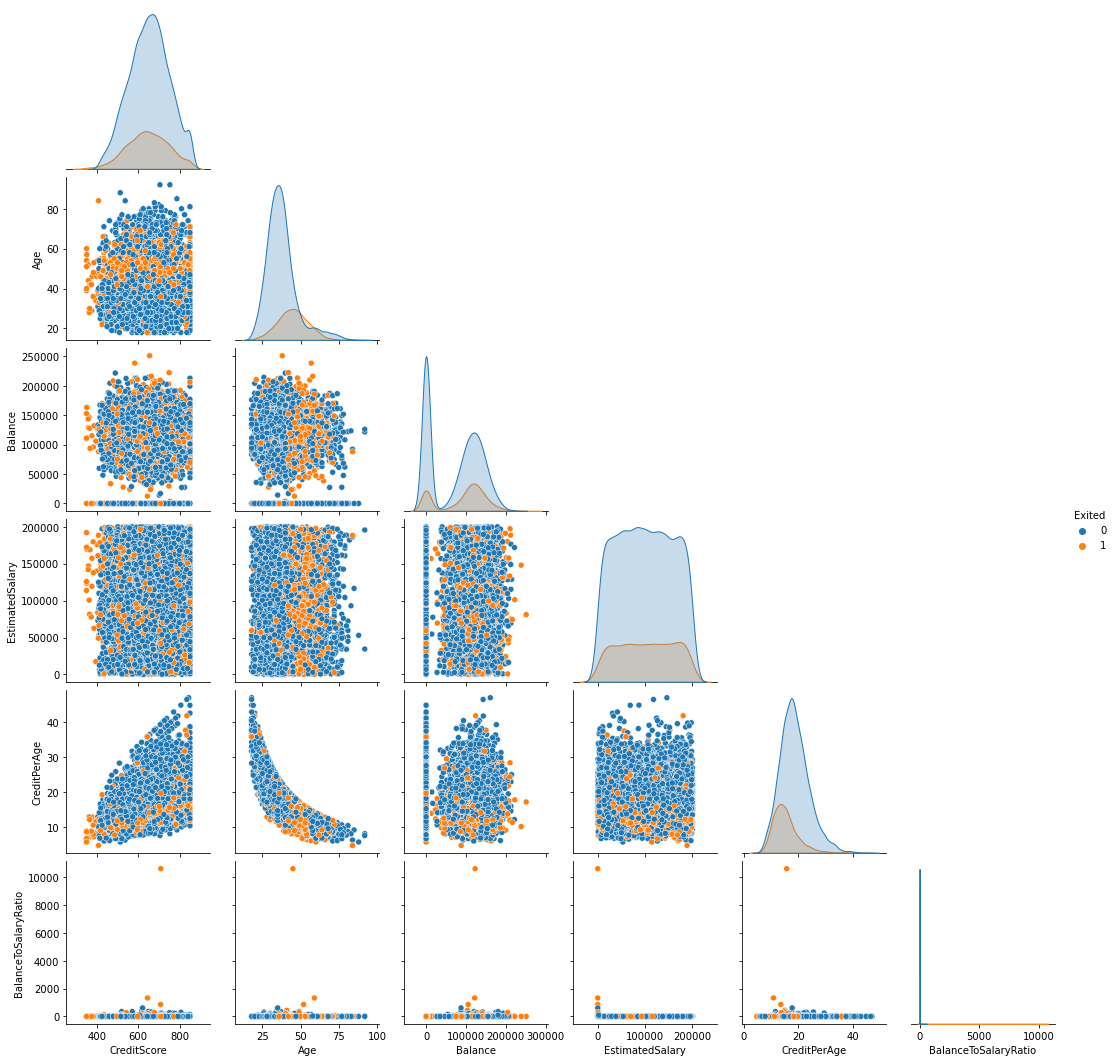

In [12]:
# Feature selection and correlation analysis
selected_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'CreditPerAge', 'BalanceToSalaryRatio', 'Exited']
df_selected = data[selected_features]
sns.pairplot(df_selected, hue="Exited", corner=True)
plt.show()

In [13]:
# Data preprocessing
X = data.drop(['RowNumber', 'CustomerID', 'Surname', 'Exited'], axis=1)
y = data['Exited']

In [14]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['Geography', 'Gender', 'IsActiveMember', 'HasCrCard', 'NumOfProducts'])


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)


In [27]:
X_train.head(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,CreditPerAge,BalanceToSalaryRatio,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0,IsActiveMember_1,HasCrCard_0,HasCrCard_1,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
5866,735,53,8,123845.36,170454.93,13.867925,0.726558,1,0,0,1,0,0,1,1,0,0,1,0,0
1938,518,38,3,90957.81,162304.59,13.631579,0.560414,1,0,0,0,1,0,1,1,0,1,0,0,0


In [28]:
X_test.head(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,CreditPerAge,BalanceToSalaryRatio,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0,IsActiveMember_1,HasCrCard_0,HasCrCard_1,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
2605,635,34,5,98683.47,15733.19,18.676471,6.272312,0,0,1,1,0,1,0,0,1,0,1,0,0
9717,757,30,3,145396.49,198341.15,25.233333,0.733063,0,0,1,0,1,0,1,1,0,1,0,0,0


In [16]:
# Model training with XGBoost
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])


[0]	validation_0-auc:0.83721
[1]	validation_0-auc:0.84702
[2]	validation_0-auc:0.85281
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85917
[5]	validation_0-auc:0.85945
[6]	validation_0-auc:0.86126
[7]	validation_0-auc:0.86210
[8]	validation_0-auc:0.86288
[9]	validation_0-auc:0.86348
[10]	validation_0-auc:0.86354
[11]	validation_0-auc:0.86356
[12]	validation_0-auc:0.86484
[13]	validation_0-auc:0.86592
[14]	validation_0-auc:0.86550
[15]	validation_0-auc:0.86555
[16]	validation_0-auc:0.86651
[17]	validation_0-auc:0.86655
[18]	validation_0-auc:0.86697
[19]	validation_0-auc:0.86713
[20]	validation_0-auc:0.86639
[21]	validation_0-auc:0.86568
[22]	validation_0-auc:0.86501
[23]	validation_0-auc:0.86488
[24]	validation_0-auc:0.86478
[25]	validation_0-auc:0.86454
[26]	validation_0-auc:0.86426
[27]	validation_0-auc:0.86433
[28]	validation_0-auc:0.86462
[29]	validation_0-auc:0.86438


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

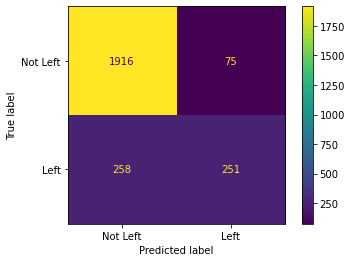

In [17]:
# Model evaluation
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [18]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [19]:
grid_search = GridSearchCV(clf_xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [20]:
# Train the final model with the best parameters
final_model = xgb.XGBClassifier(objective='binary:logistic', seed=42, **best_params)
final_model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.81064
[1]	validation_0-auc:0.81887
[2]	validation_0-auc:0.82091
[3]	validation_0-auc:0.82601
[4]	validation_0-auc:0.83450
[5]	validation_0-auc:0.84259
[6]	validation_0-auc:0.84156
[7]	validation_0-auc:0.84335
[8]	validation_0-auc:0.84606
[9]	validation_0-auc:0.84668
[10]	validation_0-auc:0.84821
[11]	validation_0-auc:0.85062
[12]	validation_0-auc:0.85414
[13]	validation_0-auc:0.85396
[14]	validation_0-auc:0.85431
[15]	validation_0-auc:0.85507
[16]	validation_0-auc:0.85727
[17]	validation_0-auc:0.85914
[18]	validation_0-auc:0.86066
[19]	validation_0-auc:0.86154
[20]	validation_0-auc:0.86258
[21]	validation_0-auc:0.86361
[22]	validation_0-auc:0.86441
[23]	validation_0-auc:0.86516
[24]	validation_0-auc:0.86575
[25]	validation_0-auc:0.86616
[26]	validation_0-auc:0.86765
[27]	validation_0-auc:0.86796
[28]	validation_0-auc:0.86826
[29]	validation_0-auc:0.86895
[30]	validation_0-auc:0.86951
[31]	validation_0-auc:0.86946
[32]	validation_0-auc:0.87043
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

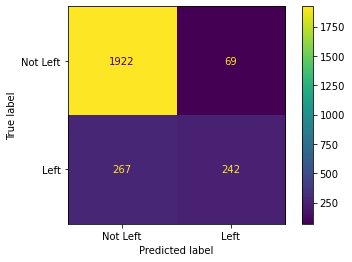

Accuracy: 0.8656
Precision: 0.7781
Recall: 0.4754
F1 Score: 0.5902


In [25]:
# Model evaluation
predictions = final_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

# Calculate and print additional metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")